# Импортирование библиотек и загрузка датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols

Данные  

Игра содержит особое событие – ивент, для прохождения которого пользователи могут тратить деньги. Группа дизайнеров решила поменять вид окошка покупки ивентовых продуктов. Чтобы оценить результат нововведения, провели АБ тест, разделив пользователей на две группы: контрольную и тестовую (с окошком нового типа). 

Задача  
Исследовать какая из АБ групп лучше себя показала.
Результаты предоставить в понятной для широкой аудитории форме, сопроводив по необходимости графиками/дашбордами/числами.
Колонки
1. AbGroup – имя АБ группы: Control/Test
2. user_id – id пользователя
3. time_stamp – день события
4. install_date – день установки приложения пользователем
5. event_name – техническое название события (InAppPurchase - в случае покупки за деньги, ResourceSpend в случае покупки за игровую валюту)
6. platform – платформа google / itunes
7. network_name – пользователь установил игру по переходу с рекламы (Paid) или нет (Organic)
8. country_name – страна пользователя
9. InGameTime – сколько всего пользователь провел в игре секунд
10. LastCompletedLevel – номер последнего пройденного уровня
11. avg_energy_amount – сколько в среднем энергии было у пользователя за день
12. revenue_on_event – ревеню, потраченное на покупку ивентовых продуктов
13. revenue_on_other_activities – ревеню, потраченное на остальные продукты, включая золото
14. gold_on_event – золото, потраченное на ивентный прогресс
15. gold_on_other_activities – золото, потраченное на другие продукты

https://drive.google.com/file/d/1ynnyIKbT64yoi0IpMd_Gs3I-n1m61QT-/view?usp=sharing

In [2]:
df = pd.read_csv('C:/Users/marcs/Downloads/test_task_product_analyst_2021_20210427.csv')

# Анализ данных

In [3]:
df.head()

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN


In [4]:
df.describe()

,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
count,6.968400e+05,696840.000000,6.968400e+05,696840.0,696840.0,45412.000000,168193.000000
mean,2.448543e+06,426.099963,1.485821e+05,0.0,0.0,1992.865322,936.481899
std,1.210664e+08,434.405962,1.764010e+07,0.0,0.0,3895.541280,3522.989145
min,-2.128381e+09,-1.000000,0.000000e+00,0.0,0.0,500.000000,100.000000
25%,3.314100e+04,59.000000,3.700000e+01,0.0,0.0,500.000000,500.000000
50%,1.729600e+05,245.000000,5.200000e+01,0.0,0.0,1000.000000,600.000000
75%,5.094630e+05,735.000000,7.300000e+01,0.0,0.0,2400.000000,1000.000000
max,2.139124e+09,1299.000000,2.123448e+09,0.0,0.0,189600.000000,755950.000000


### 1. Проверка на количество уникальных пользователей в каждой из групп 

In [5]:
df.groupby('AbGroup').user_id.agg(['count', 'nunique'])

,count,nunique
AbGroup,,
Control,558070,89034
Test,138770,22278


In [6]:
t = df.groupby('AbGroup').user_id.agg(['count', 'nunique'])
t['nunique'][0]/t['nunique'][1], t['count'][0]/t['count'][1]

(3.9964987880420146, 4.021546443755855)

Видим, что соотношение уникальных пользователей в группах равно 4/1.

### 2. Определим активность участия в ивэнте(количество пользователей в день) в зависимоти от времени

* Переведем указанное время('time_stamp', 'install_date') в размерность времени.

In [7]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'],format='%Y-%m-%d')

In [8]:
df['install_date'] = pd.to_datetime(df['install_date'],format='%Y-%m-%d')

In [9]:
df.dtypes

AbGroup                                object
user_id                                object
time_stamp                     datetime64[ns]
install_date                   datetime64[ns]
event_name                             object
platform                               object
network_name                           object
country_name                           object
InGameTime                              int64
LastCompletedLevel                      int64
avg_energy_amount                     float64
revenue_on_event                      float64
revenue_on_other_activities           float64
gold_on_event                         float64
gold_on_other_activities              float64
dtype: object

* Построим график распределения активности пользователей по дням

Text(0, 0.5, 'Число пользователей')

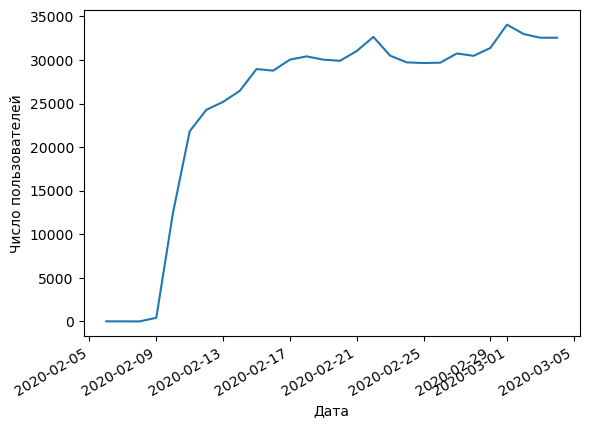

In [10]:
a = df.groupby('time_stamp').user_id.count().plot()
a.set_xlabel('Дата')
a.set_ylabel('Число пользователей')

Эксперимент длился месяц. В первые четыре был простой по посещаемости.

### 3. Оценим ревеню по событию и иным активонстям пользователей

In [11]:
df['revenue_on_event'].describe()

count    696840.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: revenue_on_event, dtype: float64

In [12]:
df['revenue_on_other_activities'].describe()

count    696840.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: revenue_on_other_activities, dtype: float64

Данные по ревеню отсутствуют в таблице, оба столбца принимают только нулевые значения.

### 4.Оценим золото(игровую валюту) по событию и иным активонстям пользователей

* Золото потраченное на иные активности.

Text(0, 0.5, 'Количество игроков потративших золото')

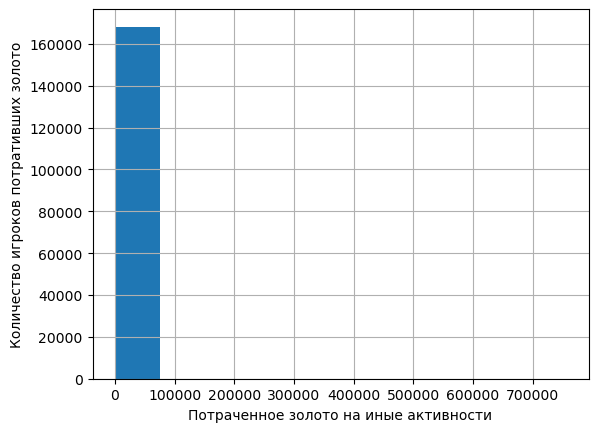

In [13]:
b = df['gold_on_other_activities'].hist()
b.set_xlabel('Потраченное золото на иные активности')
b.set_ylabel('Количество игроков потративших золото')

* Золото потраченное на ивенте.

Text(0, 0.5, 'Количество игроков потративших золото')

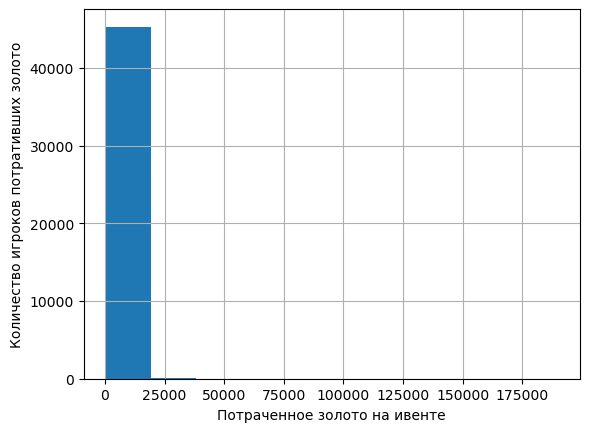

In [14]:
d = df['gold_on_event'].hist()
d.set_xlabel('Потраченное золото на ивенте')
d.set_ylabel('Количество игроков потративших золото')

Из гистограмм 'золото, потраченное на ивентный прогресс', 'золото, потраченное на другие продукты' видно что траты имеют длиннохвостовое распределение, с малым количеством пользователей, которые тратят много больше остальных.

In [15]:
len(df[df['gold_on_other_activities']>100000]) #количеством пользователей, 
# которые потралити больше 100000 единиц золота на иные активночти

15

In [16]:
len(df[df['gold_on_event']>50000]) #количеством пользователей, 
# которые потралити больше 50000 единиц золота на ивентовы процесс

30

In [17]:
gooa = len(df[df['gold_on_other_activities']>100000])/len(df)*100
goe = len(df[df['gold_on_event']>50000])/len(df)*100
print(f'Процент пользователей, потративших больше 100000 ед.золота на иные активности: {gooa:.3f}%',\
      f'Процент пользователей, потративших больше 50000 ед.золота на ивенте: {goe:.3f}%', sep='\n')

Процент пользователей, потративших больше 100000 ед.золота на иные активности: 0.002%
Процент пользователей, потративших больше 50000 ед.золота на ивенте: 0.004%


 Видно что выпадающие значения составляют малую часть выборок.

 Для 'gold_on_other_activities' основное колличество трат не превышает 100 тыс. единиц золота, выбросы же доходят до 700 тыс..

 Для 'gold_on_event' основное колличество трат не превышает 50 тыс. единиц золота, выбросы же доходят до 175 тыс..
 
Выбросы могут сильно повлить на результаты оценивания, поэтому при дальнейшем анализе, будем учитывать их наличие.

### 5. Определим пользователей которые тратили игровую валюту на протяжении ивента

* Оценим показатели в тестовой и контрольной группе по тратам золота.

In [18]:
df['gold_on_event_flag'] = (df['gold_on_event'] > 0)*1
df['gold_on_other_activities_flag'] = (df['gold_on_other_activities'] > 0)*1

In [19]:
t = df.groupby('AbGroup').\
            agg({'gold_on_event_flag': ['count', 'mean'],\
                 'gold_on_other_activities_flag': ['count', 'mean'],\
                 'gold_on_event': ['count', 'mean'],\
                 'gold_on_other_activities': ['count', 'mean']}).reset_index()
t

AbGroup gold_on_event_flag          gold_on_other_activities_flag  \
                        count     mean                         count   
0  Control             558070  0.06523                        558070   
1     Test             138770  0.06492                        138770   

            gold_on_event              gold_on_other_activities               
       mean         count         mean                    count         mean  
0  0.241385         36403  1965.211658                   134710   911.892213  
1  0.241284          9009  2104.606505                    33483  1035.412000

* gold_on_event_flag - те кто тратил золото на ивенте
* gold_on_other_activities_flag - те кто тратил золото на иные активности

In [20]:
df.groupby('AbGroup').\
            agg({'gold_on_event_flag': ['count', 'mean'],\
                 'gold_on_event': ['mean', 'median']})

gold_on_event_flag          gold_on_event        
                     count     mean          mean  median
AbGroup                                                  
Control             558070  0.06523   1965.211658  1000.0
Test                138770  0.06492   2104.606505  1500.0

Видно что в тестовой и контрольной группе потраченные деньги по среднему и медиане различаются.

* Рассчитаем на каждого пользователя в среднем и по медиане сколько он тратил на ивенте.

In [21]:
metrix = df.groupby(['user_id', 'AbGroup']).agg({'gold_on_event': ['median', 'mean'],\
                                        'gold_on_event_flag': ['count', 'mean']}).reset_index()

In [22]:
metrix.columns = ['_'.join(el) for el in metrix.columns]

In [23]:
metrix.head()

,user_id_,AbGroup_,gold_on_event_median,gold_on_event_mean,gold_on_event_flag_count,gold_on_event_flag_mean
0,00000d6d79ec151d74c5b0c0705d9d9fe252fe83,Control,NaN,NaN,2,0.000000
1,000133682d2dcd90c1a9c8ca5e34a294f31af64f,Control,1250.0,1250.0,19,0.105263
2,0001f13b0535b174bc7e36a1846c31c7a091c4b0,Control,NaN,NaN,11,0.000000
3,00021d57aced59fbfaf63ba620afada82fc06ca8,Test,NaN,NaN,13,0.000000
4,00027b7d34e10c17bfd4f76aa626403a2c5d1044,Test,NaN,NaN,7,0.000000


In [24]:
metrix.groupby('AbGroup_').mean()

,gold_on_event_median,gold_on_event_mean,gold_on_event_flag_count,gold_on_event_flag_mean
AbGroup_,,,,
Control,2002.976135,2119.778819,6.268055,0.031600
Test,2296.811371,2417.938571,6.229015,0.030891


По данной таблице, оценивая медиану и среднее, можно сказать, что траты игровой валюты в среднем на одного пользователя вырасли в тестовой группе.

# Определение различий между группами

In [25]:
group_sizes = df.AbGroup.value_counts().values

In [26]:
group_sizes #Определили размер тестовой и контрольной групп

array([558070, 138770], dtype=int64)

### 1.Сформулируем гипотезы:
* H0 - Между тестовой и контрольной группами, в поведени на ивенте нет различий(всё есть одна генеральная совокупность)
* H1 - Между тестовой и контрольной группами, в поведении на ивенте есть различия

 При верности нулевой гипотезы, можем полагать, что поведение пользователей на ивенте(трата игровой валюты), не зависит от группы(является единой гениральной совокупностью). Для проверки данной гипотезы мы будем многократно извлекать отдельные выборки пользователей из обеих групп с повторениями, размерами с контрольную и тестовую. Далее будем высчитывать разницу между средними обеих выборок и строить гистограмму распределения данных значений. 
 
 При верности нулевой гипотезы, среднее разностей между выборками должно быть близко к нулю(так как по гипотезе выборки из одной генеральной совокупности), при явном сдвиге среднего от нуля этих разностей, можно будет оценить на сколько значимые различия мы получили.


#### Таким способом проведем анализ трат золота во время ивента

  0%|          | 0/3000 [00:00<?, ?it/s]

<AxesSubplot:>

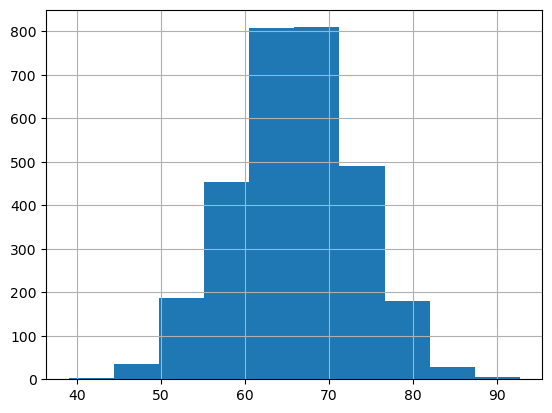

In [27]:
n = 3000
result = list()
cntrl = df[(df.gold_on_event <= 50000)&(df['AbGroup']=='Control')]
ctr = cntrl.gold_on_event
test = df[(df.gold_on_event <= 50000)&(df['AbGroup']=='Test')]
tst = test.gold_on_event
for _ in tqdm(range(n)):
    c = ctr.sample(group_sizes[0], replace=True)
    t = tst.sample(group_sizes[1], replace=True)
    
    result.append(t.mean()-c.mean())
ans = pd.Series(result)
ans.hist()

In [28]:
a = f'Разница трат золота во время ивента в тестовой и контрольной группах оказывалась в {(ans<0).mean()*100: 0.2f}% меньше нуля.'
b = f'Разница трат золота во время ивента в тестовой и контрольной группах оказывалась в {(ans<40).mean()*100: 0.2f}% меньше 40.'
print(a, b, sep = '\n')

Разница трат золота во время ивента в тестовой и контрольной группах оказывалась в  0.00% меньше нуля.
Разница трат золота во время ивента в тестовой и контрольной группах оказывалась в  0.03% меньше 40.


In [29]:
conf1 = 0.95
conf2 = 0.99
conf_int1 = st.norm.interval(confidence=conf1,
                 loc=np.mean(ans),
                 scale=st.sem(ans))
conf_int2 = st.norm.interval(confidence=conf2,
                 loc=np.mean(ans),
                 scale=st.sem(ans))
a = f'{conf1*100} % доверительный интервал для среднего разности трат золота во время ивента:\
                                                [{conf_int1[0]: 0.2f} -{conf_int1[1]: 0.2f} ]'
b = f'{conf2*100} % доверительный интервал для среднего разности трат золота во время ивента:\
                                                [{conf_int2[0]: 0.2f} -{conf_int2[1]: 0.2f} ]'
print(a, b, sep = '\n')

95.0 % доверительный интервал для среднего разности трат золота во время ивента:                                                [ 65.67 - 66.20 ]
99.0 % доверительный интервал для среднего разности трат золота во время ивента:                                                [ 65.59 - 66.28 ]


При многократном извлечении выборок трат золота во время ивента из тестовой и контрольной групп, высчитанная разность их средних, в 0.03% случаев оказывалась меньше 40. Разница равная 40 (и нулю темболее) не попадает ни в 95%, ни в 99% доверительный интервалы.

#### Аналогичную процедуру проведем для анализа трат золота на иныте активности.

  0%|          | 0/3000 [00:00<?, ?it/s]

<AxesSubplot:>

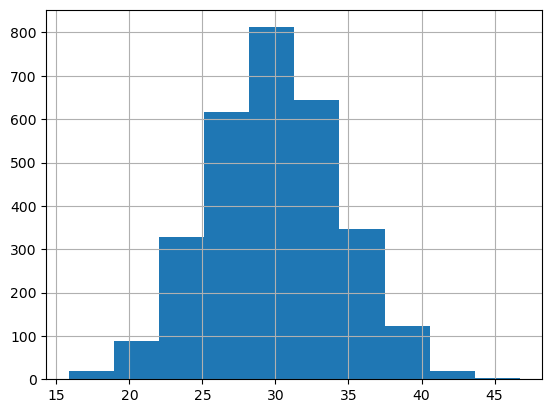

In [30]:
n = 3000
result2 = list()
cntrl = df[(df.gold_on_other_activities <= 70000)&(df['AbGroup']=='Control')]
ctr = cntrl.gold_on_other_activities
test = df[(df.gold_on_other_activities <= 70000)&(df['AbGroup']=='Test')]
tst = test.gold_on_other_activities
for _ in tqdm(range(n)):
    c = ctr.sample(group_sizes[0], replace=True)
    t = tst.sample(group_sizes[1], replace=True)
    
    result2.append(t.mean()-c.mean())
ans2 = pd.Series(result2)
ans2.hist()

In [31]:
a = f'Разница трат золота в тестовой и контрольной группах на иные активности \
оказывалась в {(ans2<0).mean()*100: 0.2f}% меньше нуля.'
b = f'Разница трат золота в тестовой и контрольной группах на иные активности \
оказывалась в {(ans2<15).mean()*100: 0.2f}% меньше 15.'
print(a, b, sep = '\n')

Разница трат золота в тестовой и контрольной группах на иные активности оказывалась в  0.00% меньше нуля.
Разница трат золота в тестовой и контрольной группах на иные активности оказывалась в  0.00% меньше 15.


In [32]:
conf1 = 0.95
conf2 = 0.99
conf_int1 = st.norm.interval(confidence=conf1,
                 loc=np.mean(ans2),
                 scale=st.sem(ans2))
conf_int2 = st.norm.interval(confidence=conf2,
                 loc=np.mean(ans2),
                 scale=st.sem(ans2))
a = f'{conf1*100} % доверительный интервал для среднего разности трат золота на иные активности:\
                                                [{conf_int1[0]: 0.2f} -{conf_int1[1]: 0.2f} ]'
b = f'{conf2*100} % доверительный интервал для среднего разности трат золота на иные активности:\
                                                [{conf_int2[0]: 0.2f} -{conf_int2[1]: 0.2f} ]'
print(a, b, sep = '\n')

95.0 % доверительный интервал для среднего разности трат золота на иные активности:                                                [ 29.78 - 30.10 ]
99.0 % доверительный интервал для среднего разности трат золота на иные активности:                                                [ 29.73 - 30.15 ]


При многократном извлечении выборок трат золота на иные активности из тестовой и контрольной групп, высчитанная разность их средних, в 0 % случаев оказывалась меньше 15 (и нуля соответственно). Разница равная 15 (и нулю темболее) не попадает ни в 95%, ни в 99% доверительный интервалы.


### Изучим какой вклад в изменчивость поведения пользователей вносят различные факторы

#### Фактор - network_name

In [33]:
df.groupby(['AbGroup', 'network_name']).agg({'gold_on_event': ['mean', 'count'],\
                                            'gold_on_other_activities': ['mean', 'count']})

gold_on_event        gold_on_other_activities       
                              mean  count                     mean  count
AbGroup network_name                                                     
Control Organic        1947.891073  14652               919.771439  47121
        Paid           1976.879224  21751               907.653358  87589
Test    Organic        2155.763150   3479              1131.343090  11548
        Paid           2072.423146   5530               984.907682  21935

#### Для оценки влияния фактора, проведем двухфакторный дисперсионный анализ.

* Изучим влияния факторов 'AbGroup' и 'netwotk_name' на показатель 'gold_on_event'

In [34]:
anova_goe = df[['AbGroup', 'network_name', 'gold_on_event']]
anova_goe = anova_goe[anova_goe.gold_on_event.isna()==False]
anova_goe.head()

,AbGroup,network_name,gold_on_event
4,Control,Paid,500.0
26,Control,Organic,500.0
31,Control,Organic,1000.0
35,Control,Paid,1000.0
53,Control,Paid,500.0


In [35]:
model = ols('gold_on_event ~ C(AbGroup) + C(network_name) + C(AbGroup):C(network_name)', data=anova_goe).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(AbGroup),1.400720e+08,1.0,9.231867,0.002380
C(network_name),5.276996e+05,1.0,0.034780,0.852059
C(AbGroup):C(network_name),2.166130e+07,1.0,1.427653,0.232154
Residual,6.889604e+11,45408.0,NaN,NaN


Фактор AbGroup: с вероятностью 95% принимаем, что траты золота на ивенте зависит от группы A/B - теста.

Фактор network_name: с вероятностью 95% принимаем, что способ установления игры (по переходу с рекламы (Paid) или нет (Organic)) не влияет на траты зоволта во время ивента.

* Изучим влияния факторов 'AbGroup' и 'netwotk_name' на показатель 'gold_on_other_activities'

In [36]:
anova_gooa = df[['AbGroup', 'network_name', 'gold_on_other_activities']]
anova_gooa = anova_gooa[anova_gooa.gold_on_other_activities.isna()==False]
anova_gooa.head()

,AbGroup,network_name,gold_on_other_activities
7,Test,Paid,1200.0
10,Test,Paid,1700.0
12,Control,Organic,200.0
13,Control,Organic,250.0
17,Control,Paid,600.0


In [37]:
model = ols('gold_on_other_activities ~ C(AbGroup) + C(network_name) + C(AbGroup):C(network_name)', data=anova_gooa).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(AbGroup),4.104084e+08,1.0,33.075445,8.880414e-09
C(network_name),5.726457e+07,1.0,4.615040,3.169417e-02
C(AbGroup):C(network_name),1.094575e+08,1.0,8.821351,2.977682e-03
Residual,2.086931e+12,168189.0,NaN,NaN


Фактор AbGroup: с вероятностью 95% принимаем, что траты золота на ивенте зависит от группы A/B - теста.

Фактор network_name: с вероятностью 95% принимаем, что способ установления игры (по переходу с рекламы (Paid) или нет (Organic)) влияет на траты зоволта во время ивента. Те кто установили игру с перехода по рекламе тратят меньше.

Так же наблюдается статистически значимое взаимодействие этих факторов.

In [38]:
als = df[(df.gold_on_other_activities <= 70000)]
als.groupby('network_name').gold_on_other_activities.mean()

network_name
Organic    926.841118
Paid       898.431679
Name: gold_on_other_activities, dtype: float64

Фактор - platform, изучить влияние невозможно, так как в таблице представлены только пользователи из itunes.

Фактор - event_name, изучить влияние невозможно, так как в таблице представлены только значения ResourceSpend.

# Выводы:
* Соотношение уникальных пользователей в контрольной и тестовой группах равняется 4/1
* В первые 4 дня наблюдался простой в активности
* Были обнаружены сильные выбросы в тратах золота на ивенте и тратах золота на иные активности
* Была выявленя явня разность в трате игровой валюты на ивенте(золото) в тестовой и контрольной группе. В тесторой группе траты золота вырасли на 65.59 - 66.28 ед. золота с 99% вероятностью
* Была выявленя явня разность в трате игровой валюты на иные активности (золото) в тестовой и контрольной группе. В тесторой группе траты золота вырасли на 29.73 - 30.15 ед. золота с 99% вероятностью
* Фактор 'network_name' не оказывает влияния на трату игровой валюты (золота) во время ивента
* Фактор 'network_name' оказывает влияния на трату игровой валюты (золота) на иные активности (те кто установили игру с перехода по рекламе тратят меньше)